# GARCH-机器学习混合模型的中国A股市场风险价值(VaR)预测增强研究

In [1]:
# 导入必要库
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf

# 统计检验相关
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

# GARCH模型相关
from arch import arch_model
from arch.unitroot import ADF

# 机器学习相关 - 使用PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 检查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cuda


# 1. 数据获取与预处理

In [3]:
def download_sse_data(start_date="2005-01-01", end_date="2024-06-30"):
    """
    下载上证综合指数数据
    """
    print("正在下载上证综合指数数据...")
    sse_ticker = "000001.SS"
    data = yf.download(sse_ticker, start=start_date, end=end_date)
    if data.empty:
        # 备用方案，使用tushare
        print("尝试使用备用数据源...")
        import tushare as ts
        ts.set_token('2207b01a244311f7742512463d9e1588954d174b86d695f8a9f1cc4b')
        pro = ts.pro_api()
        data = pro.index_daily(ts_code='000001.SH', start_date=start_date.replace('-',''), 
                                end_date=end_date.replace('-',''))
        data['Adj Close'] = data['close']
        data.index = pd.to_datetime(data['trade_date'])
        data = data.sort_index()
    
    return data

# 执行获取数据
data = download_sse_data()
data.head()

正在下载上证综合指数数据...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['000001.SS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


尝试使用备用数据源...


,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount,Adj Close
trade_date,,,,,,,,,,,,
2005-01-04,000001.SH,20050104,1242.774,1260.782,1260.782,1238.179,1266.496,-23.722,-1.8730,8161770.0,4418452.072,1242.774
2005-01-05,000001.SH,20050105,1251.937,1241.682,1258.580,1235.746,1242.774,9.163,0.7373,8678651.0,4916589.345,1251.937
2005-01-06,000001.SH,20050106,1239.430,1252.493,1252.735,1234.236,1251.937,-12.507,-0.9990,7922254.0,4381370.373,1239.430
2005-01-07,000001.SH,20050107,1244.746,1239.323,1256.313,1235.508,1239.430,5.316,0.4289,8940871.0,5040041.961,1244.746
2005-01-10,000001.SH,20050110,1252.401,1243.576,1252.723,1236.089,1244.746,7.655,0.6150,7234683.0,4118291.800,1252.401


In [4]:
def calculate_returns(data):
    """
    计算对数收益率
    """
    returns = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    returns = returns.dropna()
    print(f"计算了 {len(returns)} 条对数收益率数据")
    return returns

# 计算收益率
returns = calculate_returns(data)
returns.head()

计算了 4732 条对数收益率数据


trade_date
2005-01-05    0.007346
2005-01-06   -0.010040
2005-01-07    0.004280
2005-01-10    0.006131
2005-01-11    0.004033
Name: Adj Close, dtype: float64

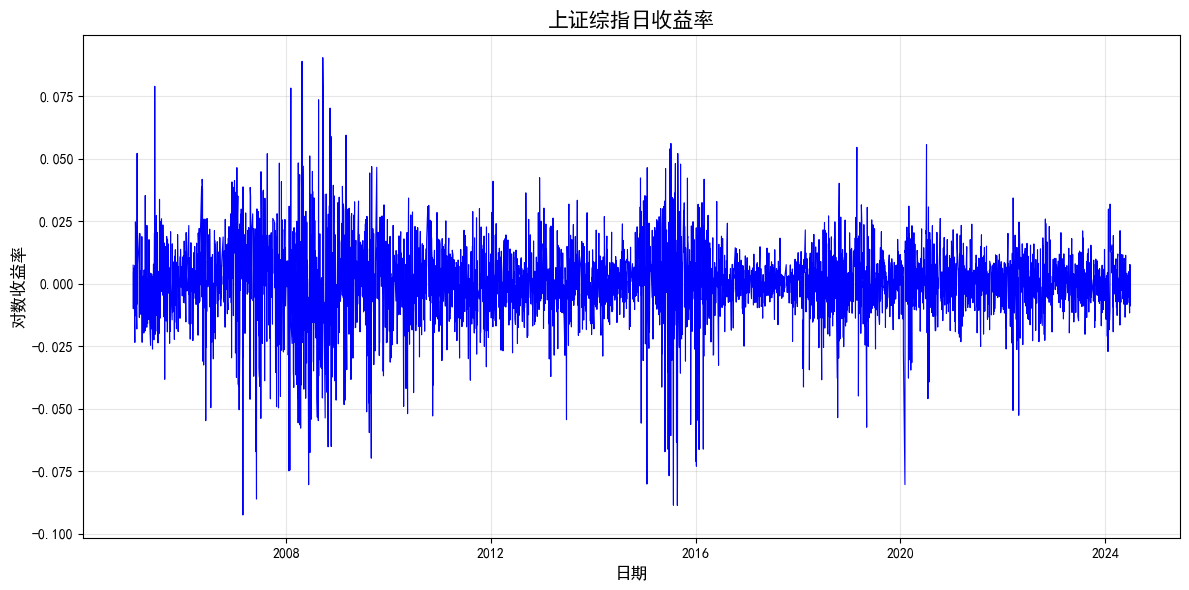

In [5]:
def plot_returns(returns, title="上证综指日收益率"):
    """
    绘制收益率时间序列图
    """
    plt.figure(figsize=(12, 6))
    plt.plot(returns.index, returns, 'b-', linewidth=0.8)
    plt.title(title, fontsize=15)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('对数收益率', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
# 绘制收益率图
plot_returns(returns)

In [6]:
def descriptive_statistics(returns):
    """
    计算并展示描述性统计
    """
    stats_dict = {
        '观测值': len(returns),
        '均值': returns.mean(),
        '中位数': returns.median(),
        '标准差': returns.std(),
        '偏度': returns.skew(),
        '峰度': returns.kurtosis(),
        '最小值': returns.min(),
        '最大值': returns.max()
    }
    
    # Jarque-Bera正态性检验
    jb_stat, jb_p = stats.jarque_bera(returns)
    stats_dict['Jarque-Bera统计量'] = jb_stat
    stats_dict['J-B p值'] = jb_p
    
    # ADF检验
    adf_result = adfuller(returns)
    stats_dict['ADF统计量'] = adf_result[0]
    stats_dict['ADF p值'] = adf_result[1]
    
    return pd.DataFrame(stats_dict, index=['统计值']).T

# 执行描述性统计
desc_stats = descriptive_statistics(returns)
print("上证综指收益率描述性统计:")
desc_stats

上证综指收益率描述性统计:


,统计值
观测值,4.732000e+03
均值,1.839267e-04
中位数,6.150000e-04
标准差,1.506250e-02
偏度,-5.796118e-01
峰度,5.233373e+00
最小值,-9.256085e-02
最大值,9.034458e-02
Jarque-Bera统计量,5.650808e+03
J-B p值,0.000000e+00


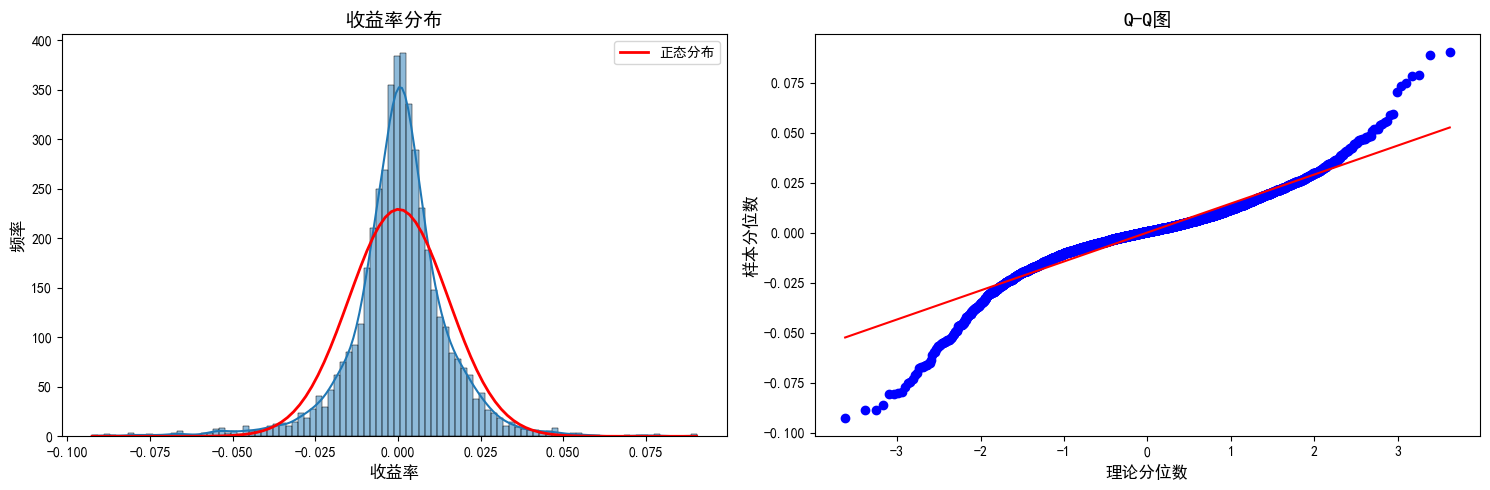

In [7]:
def plot_returns_distribution(returns):
    """
    绘制收益率分布与Q-Q图
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # 分布直方图和核密度估计
    sns.histplot(returns, kde=True, ax=axes[0], bins=100)
    axes[0].set_title('收益率分布', fontsize=14)
    axes[0].set_xlabel('收益率', fontsize=12)
    axes[0].set_ylabel('频率', fontsize=12)
    
    # 添加正态分布参考线
    x = np.linspace(returns.min(), returns.max(), 100)
    normal_rv = stats.norm(loc=returns.mean(), scale=returns.std())
    axes[0].plot(x, normal_rv.pdf(x) * len(returns) * (returns.max() - returns.min()) / 100, 
                'r-', linewidth=2, label='正态分布')
    axes[0].legend()
    
    # Q-Q图
    stats.probplot(returns, dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q图', fontsize=14)
    axes[1].set_xlabel('理论分位数', fontsize=12)
    axes[1].set_ylabel('样本分位数', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# 绘制收益率分布
plot_returns_distribution(returns)

In [8]:
def test_arch_effect(returns):
    """
    ARCH效应检验
    """
    # 先拟合AR(1)模型
    ar_model = ARIMA(returns, order=(1, 0, 0)).fit()
    residuals = ar_model.resid
    
    # ARCH-LM检验
    lags = [1, 5, 10]
    results = []
    
    for lag in lags:
        arch_test = het_arch(residuals, nlags=lag)
        results.append({
            'lag': lag,
            'LM统计量': arch_test[0],
            'p值': arch_test[1],
            '结论': '存在ARCH效应' if arch_test[1] < 0.05 else '不存在ARCH效应'
        })
    
    return pd.DataFrame(results)

# 执行ARCH效应检验
arch_test_results = test_arch_effect(returns)
print("ARCH效应检验结果:")
arch_test_results

d:\anaconda\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\envs\stock\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARCH效应检验结果:


,lag,LM统计量,p值,结论
0,1,161.986744,4.164711e-37,存在ARCH效应
1,5,427.403566,3.669575e-90,存在ARCH效应
2,10,513.455048,5.876576e-104,存在ARCH效应


# 2. GARCH模型构建与估计

In [9]:
class GARCHModel:
    def __init__(self, returns, mean_model='AR', lags=1, vol_model='GARCH', 
                 p=1, o=0, q=1, dist='normal'):
        self.returns = returns
        self.mean_model = mean_model
        self.lags = lags
        self.vol_model = vol_model
        self.p = p
        self.o = o
        self.q = q
        self.dist = dist
        self.model = None
        self.results = None
        
    def fit(self):
        """
        拟合GARCH模型
        """
        self.model = arch_model(self.returns*100, mean=self.mean_model, lags=self.lags,
                               vol=self.vol_model, p=self.p, o=self.o, q=self.q, 
                               dist=self.dist)
        self.results = self.model.fit(disp='off')
        
        return self.results
    
    def forecast_volatility(self, horizon=1):
        """
        预测条件波动率
        """
        if self.results is None:
            self.fit()
        
        forecast = self.results.forecast(horizon=horizon)
        vol_forecast = np.sqrt(forecast.variance.iloc[-1, :] / 10000)  # 转换回原始单位
        
        return vol_forecast
    
    def get_conditional_volatility(self):
        """
        获取条件波动率
        """
        if self.results is None:
            self.fit()
        
        return self.results.conditional_volatility / 100  # 转换回原始单位
    
    def get_std_residuals(self):
        """
        获取标准化残差
        """
        if self.results is None:
            self.fit()
        
        return self.results.std_resid
    
    def diagnostic_tests(self):
        """
        模型诊断检验
        """
        if self.results is None:
            self.fit()
            
        std_resid = self.results.std_resid
        
        # Ljung-Box检验标准化残差
        lb_resid = acorr_ljungbox(std_resid, lags=[5, 10, 15, 20], return_df=True)
        
        # Ljung-Box检验标准化残差平方
        lb_sq_resid = acorr_ljungbox(std_resid**2, lags=[5, 10, 15, 20], return_df=True)
        
        return lb_resid, lb_sq_resid

garch_model = GARCHModel(returns)

In [10]:
def fit_multiple_garch_models(returns, lb_lag=10):
    """
    拟合多种 GARCH / GJR-GARCH 模型并比较
    """
    # 先清理输入序列
    returns = pd.Series(returns).dropna().astype(float)

    models = {
        'GARCH(1,1)-Normal': dict(vol='Garch', p=1, o=0, q=1, dist='normal'),
        'GARCH(1,1)-t':      dict(vol='Garch', p=1, o=0, q=1, dist='t'),
        'GJR-GARCH(1,1)-Normal': dict(vol='Garch', p=1, o=1, q=1, dist='normal'),
        'GJR-GARCH(1,1)-t':      dict(vol='Garch', p=1, o=1, q=1, dist='t'),
    }

    summary_rows, fitted_models = [], {}

    for name, kwargs in models.items():
        print(f"正在拟合 {name} …")
        am   = arch_model(returns, mean='AR', lags=1, **kwargs)
        res  = am.fit(disp='off')
        fitted_models[name] = res

        # —— Ljung-Box：对标准化残差及其平方 —— #
        std_resid = res.std_resid.dropna()            # 去掉前面因延迟产生的 NaN
        lb_resid  = acorr_ljungbox(std_resid,  lags=[lb_lag], return_df=True)
        lb_sq     = acorr_ljungbox(std_resid**2, lags=[lb_lag], return_df=True)

        summary_rows.append({
            "模型"        : name,
            "Log-Likelihood": res.loglikelihood,
            "AIC"         : res.aic,
            "BIC"         : res.bic,
            f"LB-Q({lb_lag})"   : lb_resid["lb_pvalue"].iloc[0],
            f"LB-Q²({lb_lag})"  : lb_sq["lb_pvalue"].iloc[0],
        })

    summary_df = (pd.DataFrame(summary_rows)
                    .sort_values("AIC")
                    .reset_index(drop=True))
    return fitted_models, summary_df

# 拟合多种GARCH模型
garch_models, garch_comparison = fit_multiple_garch_models(returns)
print("\n不同GARCH模型比较:")
garch_comparison

正在拟合 GARCH(1,1)-Normal …
正在拟合 GARCH(1,1)-t …


d:\anaconda\envs\stock\lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


正在拟合 GJR-GARCH(1,1)-Normal …
正在拟合 GJR-GARCH(1,1)-t …

不同GARCH模型比较:


,模型,Log-Likelihood,AIC,BIC,LB-Q(10),LB-Q²(10)
0,"GARCH(1,1)-Normal",13913.137732,-27816.275465,-27783.966005,1.379335e-03,7.506597e-01
1,"GJR-GARCH(1,1)-Normal",13913.472581,-27814.945162,-27776.173810,1.241285e-03,6.624746e-01
2,"GJR-GARCH(1,1)-t",5559.585670,-11105.171340,-11059.938096,3.567496e-25,6.220052e-36
3,"GARCH(1,1)-t",-19970.065975,39952.131950,39990.903301,2.022869e-01,9.992475e-01


最优模型: GARCH(1,1)-Normal

                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                13913.1
Distribution:                  Normal   AIC:                          -27816.3
Method:            Maximum Likelihood   BIC:                          -27784.0
                                        No. Observations:                 4731
Date:                Mon, May 12 2025   Df Residuals:                     4729
Time:                        09:22:20   Df Model:                            2
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const        2.2183e-04 

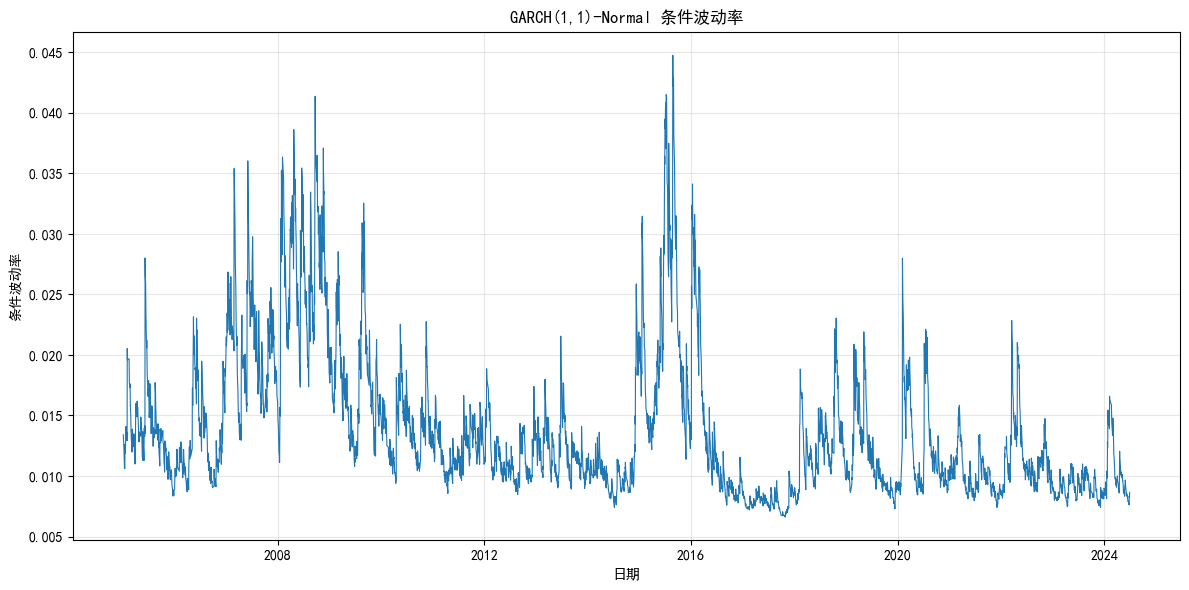

In [11]:
def analyze_best_garch_model(models, comparison_df, lb_lag=10):
    """
    分析 AIC 最优的 GARCH 模型并画出条件波动率
    """
    # 1. 取出 AIC 最小的模型
    best_name   = comparison_df.iloc[0]["模型"]
    best_result = models[best_name]          # 这是一个 ARCHModelResult

    print(f"最优模型: {best_name}\n")
    print(best_result.summary())             # 直接 summary()

    # 2. 条件波动率
    volatility = best_result.conditional_volatility
    # 若返回的是 ndarray，就补上索引
    if not isinstance(volatility, pd.Series):
        volatility = pd.Series(volatility, index=best_result.model._y.index,
                               name="cond_vol")

    # 3. 绘图
    plt.figure(figsize=(12, 6))
    plt.plot(volatility.index, volatility, linewidth=0.8)
    plt.title(f"{best_name} 条件波动率")
    plt.xlabel("日期")
    plt.ylabel("条件波动率")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return best_result, volatility

# 分析最优GARCH模型
best_garch_model, garch_volatility = analyze_best_garch_model(garch_models, garch_comparison)

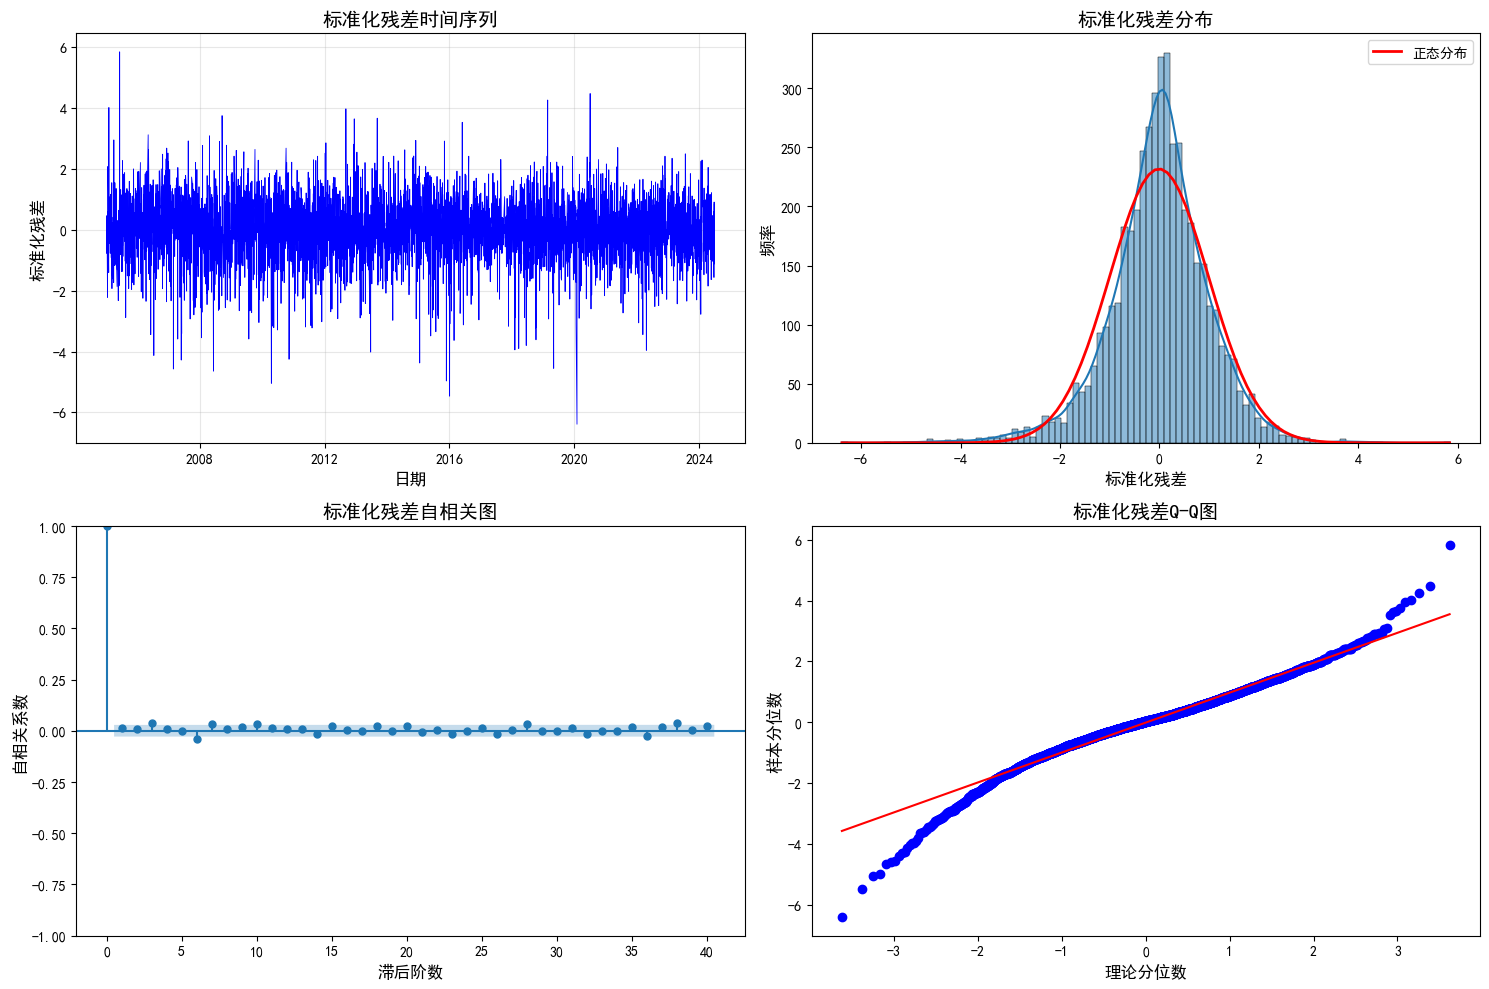

In [12]:
def analyze_garch_residuals(model):
    """
    GARCH模型残差分析
    """
    std_resid = pd.Series(model.std_resid,
                      index=model.resid.index,
                      name="std_resid").dropna()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 标准化残差时间序列
    axes[0, 0].plot(std_resid.index, std_resid, 'b-', linewidth=0.6)
    axes[0, 0].set_title('标准化残差时间序列', fontsize=14)
    axes[0, 0].set_xlabel('日期', fontsize=12)
    axes[0, 0].set_ylabel('标准化残差', fontsize=12)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 标准化残差分布
    sns.histplot(std_resid, kde=True, ax=axes[0, 1], bins=100)
    axes[0, 1].set_title('标准化残差分布', fontsize=14)
    axes[0, 1].set_xlabel('标准化残差', fontsize=12)
    axes[0, 1].set_ylabel('频率', fontsize=12)
    
    # 添加正态分布参考线
    x = np.linspace(std_resid.min(), std_resid.max(), 100)
    normal_rv = stats.norm(loc=std_resid.mean(), scale=std_resid.std())
    axes[0, 1].plot(x, normal_rv.pdf(x) * len(std_resid) * (std_resid.max() - std_resid.min()) / 100, 
                  'r-', linewidth=2, label='正态分布')
    axes[0, 1].legend()
    
    # 自相关图
    plot_acf(std_resid, ax=axes[1, 0], lags=40)  
    axes[1, 0].set_title('标准化残差自相关图', fontsize=14)
    axes[1, 0].set_xlabel('滞后阶数', fontsize=12)
    axes[1, 0].set_ylabel('自相关系数', fontsize=12)
    
    # Q-Q图
    stats.probplot(std_resid, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('标准化残差Q-Q图', fontsize=14)
    axes[1, 1].set_xlabel('理论分位数', fontsize=12)
    axes[1, 1].set_ylabel('样本分位数', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return std_resid

# 分析GARCH模型残差
std_residuals = analyze_garch_residuals(best_garch_model)

# 3. 构建PyTorch机器学习模型

In [13]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets, seq_length):
        self.features = features
        self.targets = targets
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.features) - self.seq_length
    
    def __getitem__(self, idx):
        x = self.features[idx:idx + self.seq_length]
        y = self.targets[idx + self.seq_length]
        return torch.FloatTensor(x), torch.FloatTensor([y])

In [14]:
class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout=0.3):
        super(LSTM_Model, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # 添加批标准化
        self.batch_norm = nn.BatchNorm1d(input_dim)
        
        # 减少层数和复杂度
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True  # 使用双向LSTM
        )
        
        # 增加L2正则化和注意力机制
        self.attention = nn.Linear(hidden_dim*2, 1)  # 双向LSTM，维度翻倍
        self.fc1 = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Softplus()  # 确保输出为正值
        
    def forward(self, x):
        # 应用批标准化 (调整维度以适应BatchNorm1d)
        batch_size, seq_len, feat_dim = x.size()
        x_reshaped = x.contiguous().view(-1, feat_dim)
        x_bn = self.batch_norm(x_reshaped)
        x = x_bn.view(batch_size, seq_len, feat_dim)
        
        # LSTM层
        lstm_out, _ = self.lstm(x)
        
        # 应用注意力机制
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        
        # 全连接层
        out = self.fc1(context)
        out = nn.ReLU()(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.activation(out)
        
        return out

In [15]:
class GRU_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout=0.3):
        super(GRU_Model, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # 添加批标准化
        self.batch_norm = nn.BatchNorm1d(input_dim)
        
        # 双向GRU
        self.gru = nn.GRU(
            input_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True  # 使用双向GRU
        )
        
        # 注意力机制
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        # 全连接层
        self.fc1 = nn.Linear(hidden_dim*2, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Softplus()  # 确保输出为正值
        
    def forward(self, x):
        # 应用批标准化 (调整维度以适应BatchNorm1d)
        batch_size, seq_len, feat_dim = x.size()
        x_reshaped = x.contiguous().view(-1, feat_dim)
        x_bn = self.batch_norm(x_reshaped)
        x = x_bn.view(batch_size, seq_len, feat_dim)
        
        # GRU层
        gru_out, _ = self.gru(x)  # [batch_size, seq_len, hidden_dim*2]
        
        # 应用注意力机制
        attention_scores = self.attention(gru_out).squeeze(-1)  # [batch_size, seq_len]
        attention_weights = torch.softmax(attention_scores, dim=1).unsqueeze(2)  # [batch_size, seq_len, 1]
        context = torch.sum(attention_weights * gru_out, dim=1)  # [batch_size, hidden_dim*2]
        
        # 全连接层
        out = self.fc1(context)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.activation(out)
        
        return out

In [16]:
def train_model(model, train_loader, val_loader, epochs=200, lr=0.0005, patience=15):
    """
    训练函数
    """
    criterion = nn.MSELoss()
    
    # 使用学习率调度器和更好的优化器
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # 早停
    best_val_loss = float('inf')
    counter = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # 训练模式
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # 前向传播
            output = model(X_batch)
            loss = criterion(output, y_batch)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            
            # 梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # 验证模式
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                
                output = model(X_val)
                loss = criterion(output, y_val)
                
                val_loss += loss.item()
                
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # 学习率调度
        scheduler.step(val_loss)
        
        # 打印训练过程
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
        
        # 早停检查
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # 保存最佳模型
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f'早停 at epoch {epoch+1}')
                break
    
    # 加载最佳模型
    model.load_state_dict(torch.load('best_model.pth'))
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='训练损失')
    plt.plot(val_losses, label='验证损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.title('训练与验证损失曲线')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return model, train_losses, val_losses

In [17]:
def prepare_features(returns, garch_vol, std_resid):
    """
    准备ML模型输入特征
    """
    print("准备特征数据...")
    features = pd.DataFrame({
        # 基础特征
        'garch_vol': garch_vol,
        'returns': returns,
        
        # 非线性特征
        'returns_abs': returns.abs(),
        'returns_squared': returns**2,
        
        # 波动率相关特征
        'vol_change': garch_vol.pct_change(),
        'vol_ratio': garch_vol / garch_vol.rolling(5).mean(),
        
        # 残差特征
        'std_resid': std_resid,
        'std_resid_abs': std_resid.abs(),
        'std_resid_squared': std_resid**2,
        
        # 滞后特征
        'returns_lag1': returns.shift(1),
        'returns_lag2': returns.shift(2),
        'returns_lag3': returns.shift(3),
        'garch_vol_lag1': garch_vol.shift(1),
        'garch_vol_lag2': garch_vol.shift(2),
    })
    
    # 移动窗口特征
    for window in [5, 10, 22]:
        # 收益率的移动统计量
        features[f'returns_ma{window}'] = returns.rolling(window).mean()
        features[f'returns_std{window}'] = returns.rolling(window).std()
        features[f'returns_max{window}'] = returns.rolling(window).max()
        features[f'returns_min{window}'] = returns.rolling(window).min()
        features[f'returns_range{window}'] = features[f'returns_max{window}'] - features[f'returns_min{window}']
        
        # 波动率的移动统计量
        features[f'vol_ma{window}'] = garch_vol.rolling(window).mean()
        features[f'vol_std{window}'] = garch_vol.rolling(window).std()
        
        # 残差的移动统计量
        features[f'resid_ma{window}'] = std_resid.abs().rolling(window).mean()
    
    # 市场环境特征
    features['up_market'] = (returns > 0).astype(float)
    features['down_market'] = (returns < 0).astype(float)
    features['high_vol'] = (garch_vol > garch_vol.rolling(22).mean()).astype(float)
    
    # 删除NaN值
    features = features.dropna()
    
    # 删除无限值
    features = features.replace([np.inf, -np.inf], np.nan).dropna()
    
    print(f"特征数据准备完成，共 {len(features)} 行, {features.shape[1]} 列")
    return features

# 准备特征数据
full_features = prepare_features(returns, garch_volatility, std_residuals)
full_features.head()

准备特征数据...
特征数据准备完成，共 4710 行, 41 列


,garch_vol,returns,returns_abs,returns_squared,vol_change,vol_ratio,std_resid,std_resid_abs,std_resid_squared,returns_lag1,...,returns_std22,returns_max22,returns_min22,returns_range22,vol_ma22,vol_std22,resid_ma22,up_market,down_market,high_vol
trade_date,,,,,,,,,,,,,,,,,,,,,
2005-02-04,0.019606,0.021262,0.021262,0.000452,-0.045055,1.231538,1.081590,1.081590,1.169837,-0.008171,...,0.016684,0.052087,-0.023531,0.075618,0.013240,0.002410,0.914790,1.0,0.0,1.0
2005-02-16,0.019692,0.007752,0.007752,0.000060,0.004382,1.140054,0.360638,0.360638,0.130060,0.021262,...,0.016574,0.052087,-0.023531,0.075618,0.013525,0.002776,0.895893,1.0,0.0,1.0
2005-02-17,0.018730,-0.002149,0.002149,0.000005,-0.048841,1.023457,-0.134959,0.134959,0.018214,0.007752,...,0.016578,0.052087,-0.023531,0.075618,0.013778,0.002987,0.887329,0.0,1.0,1.0
2005-02-18,0.017717,-0.013542,0.013542,0.000183,-0.054088,0.920117,-0.774438,0.774438,0.599754,-0.002149,...,0.016824,0.052087,-0.023531,0.075618,0.014010,0.003089,0.901549,0.0,1.0,1.0
2005-02-21,0.017308,0.020061,0.020061,0.000402,-0.023053,0.930034,1.162000,1.162000,1.350243,-0.013542,...,0.017335,0.052087,-0.023531,0.075618,0.014243,0.003137,0.940588,1.0,0.0,1.0


In [18]:
def prepare_targets(returns):
    # 使用5日滚动窗口计算实现波动率
    targets = returns.rolling(window=5).std() * np.sqrt(252/5)  # 年化
    
    targets = targets.dropna()
    
    print(f"目标变量准备完成，共 {len(targets)} 行")
    return targets

# 准备目标变量
targets = prepare_targets(returns)
targets.head()

目标变量准备完成，共 4728 行


trade_date
2005-01-11    0.050116
2005-01-12    0.046282
2005-01-13    0.021291
2005-01-14    0.040042
2005-01-17    0.077421
Name: Adj Close, dtype: float64

准备训练集和测试集...
训练集大小: 4210, 测试集大小: 500
开始训练LSTM模型...
Epoch 10/100 | Train Loss: 0.382681 | Val Loss: 0.493113
Epoch 20/100 | Train Loss: 0.351415 | Val Loss: 0.493421
Epoch 30/100 | Train Loss: 0.329273 | Val Loss: 0.491843
早停 at epoch 34


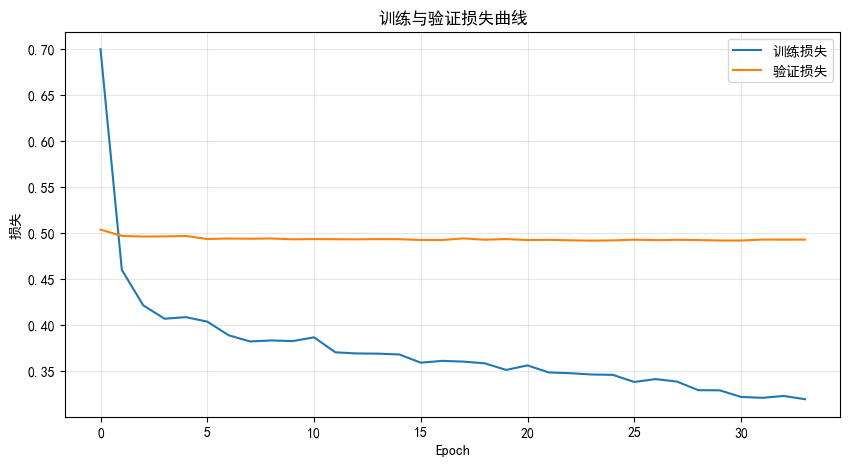

评估LSTM模型...
均方误差 (MSE): 0.001873
平均绝对误差 (MAE): 0.039042


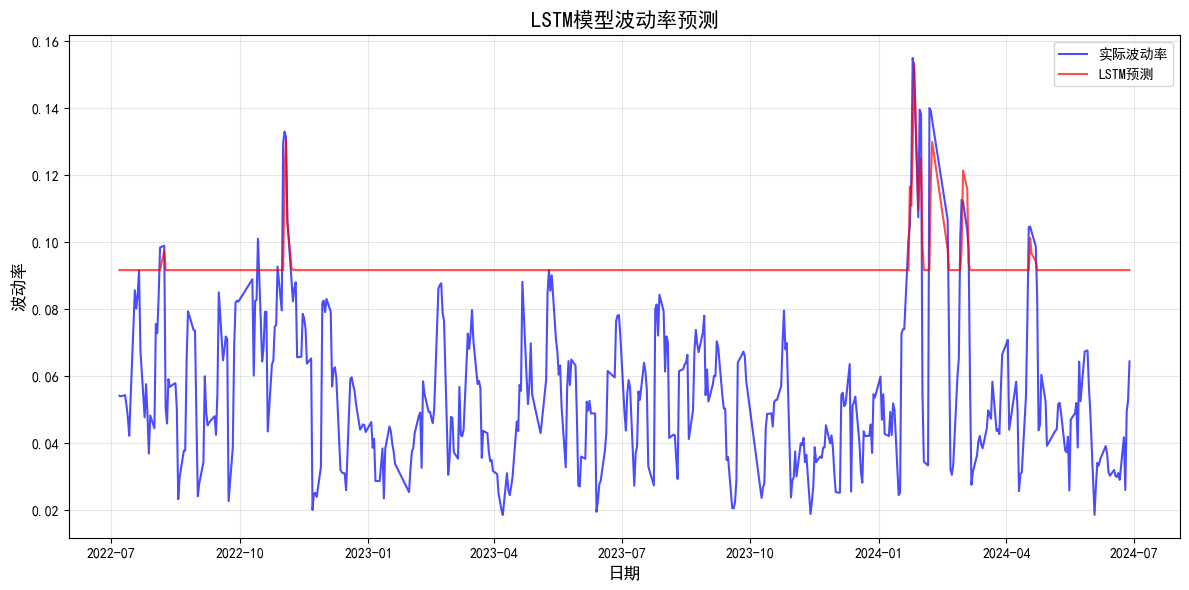

In [19]:
def train_eval_lstm(features, targets, lookback=20, test_size=500):
    """
    训练和评估LSTM模型
    """
    print("准备训练集和测试集...")

    # ---- 1. 先把 features / targets 对齐并去掉 NaN ---- #
    data = pd.concat([features, targets.rename('target')], axis=1, join='inner')
    data = data.dropna()               # 如要补齐可改成 .fillna(method='ffill') 等
    features = data[features.columns]
    targets  = data['target']

    # ---- 2. 再切训练 / 测试集 ---- #
    if test_size >= len(features):
        raise ValueError(f"test_size={test_size} 不能 >= 样本总数 {len(features)}")

    train_features = features.iloc[:-test_size]
    test_features  = features.iloc[-test_size:]
    train_targets  = targets.iloc[:-test_size]
    test_targets   = targets.iloc[-test_size:]

    print(f"训练集大小: {len(train_features)}, 测试集大小: {len(test_features)}")
    
    # 标准化特征
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    train_features_scaled = scaler_X.fit_transform(train_features)
    test_features_scaled = scaler_X.transform(test_features)
    
    train_targets_array = train_targets.values.reshape(-1, 1)
    test_targets_array = test_targets.values.reshape(-1, 1)
    
    train_targets_scaled = scaler_y.fit_transform(train_targets_array)
    test_targets_scaled = scaler_y.transform(test_targets_array)
    
    # 创建PyTorch数据集
    train_dataset = TimeSeriesDataset(
        features=train_features_scaled,
        targets=train_targets_scaled.reshape(-1),
        seq_length=lookback
    )
    
    test_dataset = TimeSeriesDataset(
        features=test_features_scaled,
        targets=test_targets_scaled.reshape(-1),
        seq_length=lookback
    )
    
    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # 创建模型
    input_dim = features.shape[1]
    hidden_dim = 64
    num_layers = 2
    
    lstm_model = LSTM_Model(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=1,
        dropout=0.2
    ).to(device)
    
    print("开始训练LSTM模型...")
    # 训练模型
    trained_lstm, lstm_train_losses, lstm_val_losses = train_model(
        model=lstm_model,
        train_loader=train_loader,
        val_loader=test_loader,
        epochs=100,
        lr=0.001,
        patience=10
    )
    
    # 评估模型
    print("评估LSTM模型...")
    trained_lstm.eval()
    
    # 预测测试集
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            output = trained_lstm(X_test)
            
            # 反归一化
            pred_np = output.cpu().numpy()
            actual_np = y_test.cpu().numpy()
            
            predictions.extend(scaler_y.inverse_transform(pred_np))
            actuals.extend(scaler_y.inverse_transform(actual_np))
    
    # 转换为Pandas Series以保留索引
    pred_series = pd.Series(np.array(predictions).flatten(), index=test_targets.index[lookback:])
    actual_series = pd.Series(np.array(actuals).flatten(), index=test_targets.index[lookback:])
    
    # 计算评估指标
    mse = mean_squared_error(actual_series, pred_series)
    mae = mean_absolute_error(actual_series, pred_series)
    
    print(f"均方误差 (MSE): {mse:.6f}")
    print(f"平均绝对误差 (MAE): {mae:.6f}")
    
    # 绘制预测结果
    plt.figure(figsize=(12, 6))
    plt.plot(actual_series.index, actual_series, label='实际波动率', color='blue', alpha=0.7)
    plt.plot(pred_series.index, pred_series, label='LSTM预测', color='red', alpha=0.7)
    plt.title('LSTM模型波动率预测', fontsize=15)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('波动率', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return trained_lstm, pred_series, actual_series, (mse, mae)

# 训练并评估LSTM模型
lstm_model, lstm_predictions, lstm_actuals, lstm_metrics = train_eval_lstm(
    features=full_features, 
    targets=targets, 
    lookback=20, 
    test_size=500
)

训练集大小: 4210, 测试集大小: 500
开始训练GRU模型...
Epoch 10/100 | Train Loss: 0.372200 | Val Loss: 0.492024
Epoch 20/100 | Train Loss: 0.348559 | Val Loss: 0.491716
早停 at epoch 28


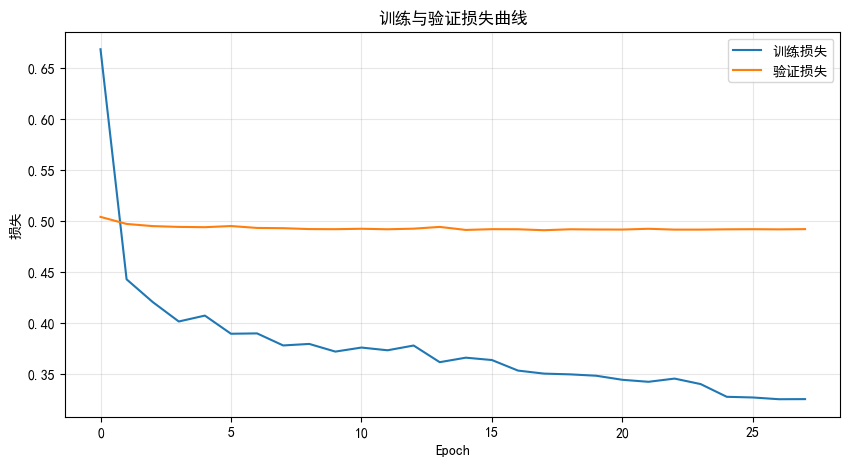

评估GRU模型...
均方误差 (MSE): 0.001870
平均绝对误差 (MAE): 0.038921


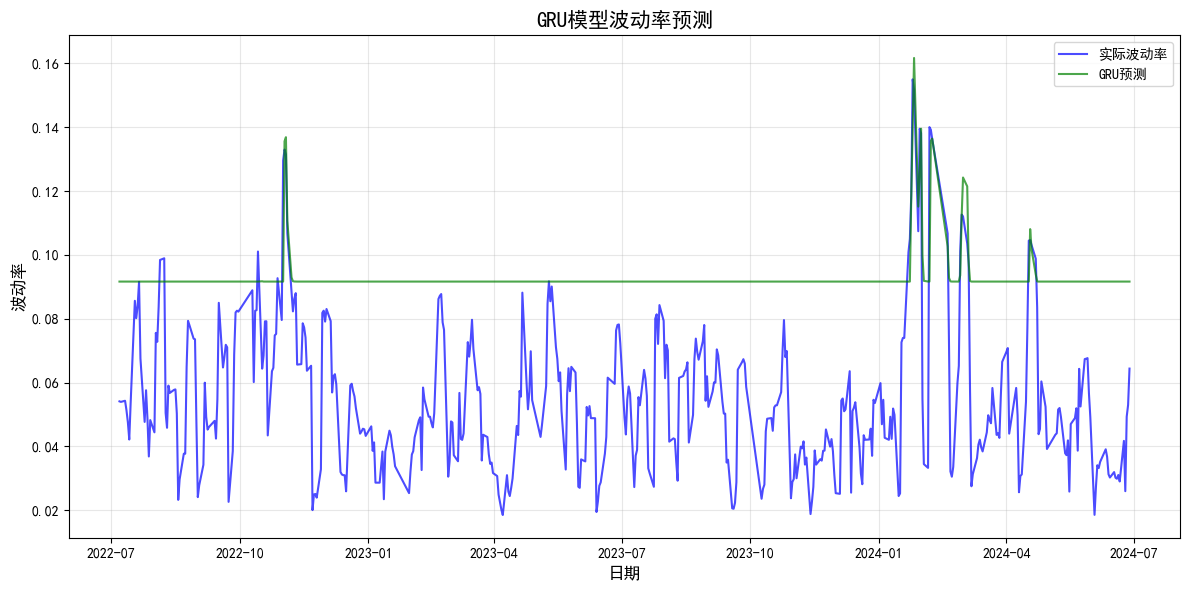

In [20]:
def train_eval_gru(features, targets, lookback=20, test_size=500):
    """
    训练和评估GRU模型
    """
    # ---- 1. 先把 features / targets 对齐并去掉 NaN ---- #
    data = pd.concat([features, targets.rename('target')], axis=1, join='inner')
    data = data.dropna()               # 如要补齐可改成 .fillna(method='ffill') 等
    features = data[features.columns]
    targets  = data['target']

    # ---- 2. 再切训练 / 测试集 ---- #
    if test_size >= len(features):
        raise ValueError(f"test_size={test_size} 不能 >= 样本总数 {len(features)}")

    train_features = features.iloc[:-test_size]
    test_features  = features.iloc[-test_size:]
    train_targets  = targets.iloc[:-test_size]
    test_targets   = targets.iloc[-test_size:]

    print(f"训练集大小: {len(train_features)}, 测试集大小: {len(test_features)}")
    
    # 标准化特征
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    train_features_scaled = scaler_X.fit_transform(train_features)
    test_features_scaled = scaler_X.transform(test_features)
    
    train_targets_array = train_targets.values.reshape(-1, 1)
    test_targets_array = test_targets.values.reshape(-1, 1)
    
    train_targets_scaled = scaler_y.fit_transform(train_targets_array)
    test_targets_scaled = scaler_y.transform(test_targets_array)
    
    # 创建PyTorch数据集
    train_dataset = TimeSeriesDataset(
        features=train_features_scaled,
        targets=train_targets_scaled.reshape(-1),
        seq_length=lookback
    )
    
    test_dataset = TimeSeriesDataset(
        features=test_features_scaled,
        targets=test_targets_scaled.reshape(-1),
        seq_length=lookback
    )
    
    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # 创建模型
    input_dim = features.shape[1]
    hidden_dim = 64
    num_layers = 2
    
    gru_model = GRU_Model(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=1,
        dropout=0.2
    ).to(device)
    
    print("开始训练GRU模型...")
    # 训练模型
    trained_gru, gru_train_losses, gru_val_losses = train_model(
        model=gru_model,
        train_loader=train_loader,
        val_loader=test_loader,
        epochs=100,
        lr=0.001,
        patience=10
    )
    
    # 评估模型
    print("评估GRU模型...")
    trained_gru.eval()
    
    # 预测测试集
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            output = trained_gru(X_test)
            
            # 反归一化
            pred_np = output.cpu().numpy()
            actual_np = y_test.cpu().numpy()
            
            predictions.extend(scaler_y.inverse_transform(pred_np))
            actuals.extend(scaler_y.inverse_transform(actual_np))
    
    # 转换为Pandas Series以保留索引
    pred_series = pd.Series(np.array(predictions).flatten(), index=test_targets.index[lookback:])
    actual_series = pd.Series(np.array(actuals).flatten(), index=test_targets.index[lookback:])
    
    # 计算评估指标
    mse = mean_squared_error(actual_series, pred_series)
    mae = mean_absolute_error(actual_series, pred_series)
    
    print(f"均方误差 (MSE): {mse:.6f}")
    print(f"平均绝对误差 (MAE): {mae:.6f}")
    
    # 绘制预测结果
    plt.figure(figsize=(12, 6))
    plt.plot(actual_series.index, actual_series, label='实际波动率', color='blue', alpha=0.7)
    plt.plot(pred_series.index, pred_series, label='GRU预测', color='green', alpha=0.7)
    plt.title('GRU模型波动率预测', fontsize=15)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('波动率', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return trained_gru, pred_series, actual_series, (mse, mae)

# 训练并评估GRU模型
gru_model, gru_predictions, gru_actuals, gru_metrics = train_eval_gru(
    features=full_features, 
    targets=targets, 
    lookback=20, 
    test_size=500
)

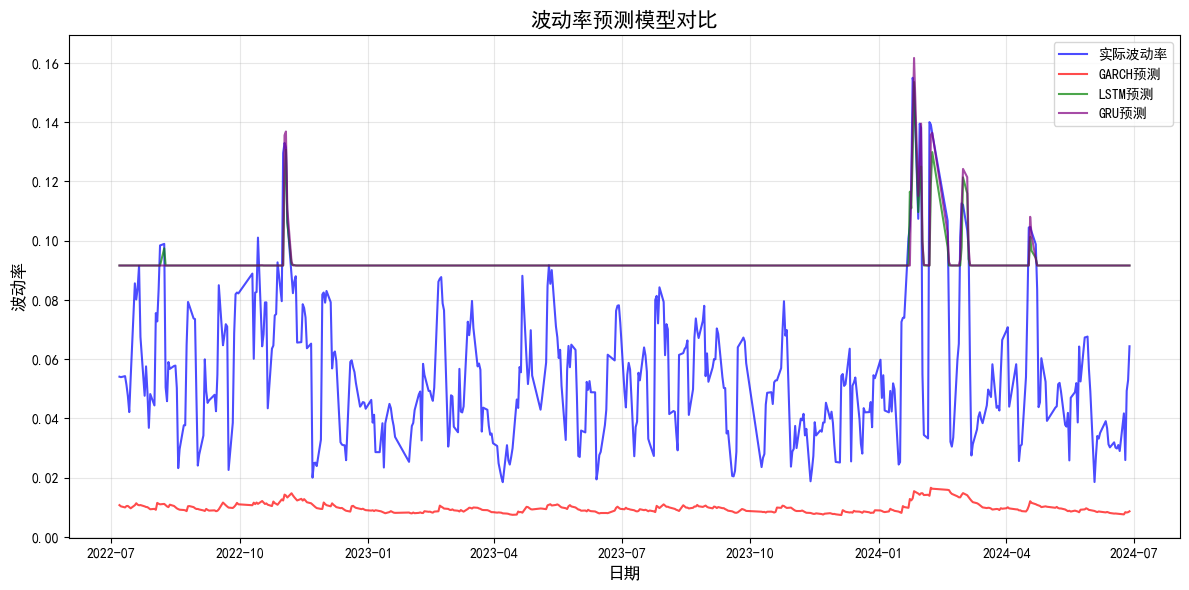

模型性能对比:


,模型,MSE,MAE
0,GARCH,0.002532,0.045016
1,LSTM,0.001873,0.039042
2,GRU,0.001870,0.038921


In [21]:
def compare_models(garch_vol, lstm_pred, gru_pred, actuals):
    """
    比较不同模型的性能
    """
    # 确保所有预测都在同一时间段
    common_index = actuals.index.intersection(lstm_pred.index).intersection(gru_pred.index)
    
    # 获取GARCH模型在同一时间段的预测
    garch_pred = garch_vol.loc[common_index]
    
    # 评估指标
    models = ['GARCH', 'LSTM', 'GRU']
    predictions = [garch_pred, lstm_pred.loc[common_index], gru_pred.loc[common_index]]
    actuals_common = actuals.loc[common_index]
    
    results = []
    
    for name, pred in zip(models, predictions):
        mse = mean_squared_error(actuals_common, pred)
        mae = mean_absolute_error(actuals_common, pred)
        
        results.append({
            '模型': name,
            'MSE': mse,
            'MAE': mae
        })
    
    results_df = pd.DataFrame(results)
    
    # 绘制对比图
    plt.figure(figsize=(12, 6))
    plt.plot(actuals_common.index, actuals_common, label='实际波动率', color='blue', alpha=0.7)
    plt.plot(garch_pred.index, garch_pred, label='GARCH预测', color='red', alpha=0.7)
    plt.plot(lstm_pred.loc[common_index].index, lstm_pred.loc[common_index], label='LSTM预测', color='green', alpha=0.7)
    plt.plot(gru_pred.loc[common_index].index, gru_pred.loc[common_index], label='GRU预测', color='purple', alpha=0.7)
    plt.title('波动率预测模型对比', fontsize=15)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('波动率', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results_df

# 比较模型性能
# 获取测试期的GARCH波动率
test_garch_vol = garch_volatility.loc[lstm_actuals.index]
model_comparison = compare_models(
    garch_vol=test_garch_vol, 
    lstm_pred=lstm_predictions, 
    gru_pred=gru_predictions, 
    actuals=lstm_actuals
)
print("模型性能对比:")
model_comparison

# 4. GARCH-ML混合模型构建与VaR计算

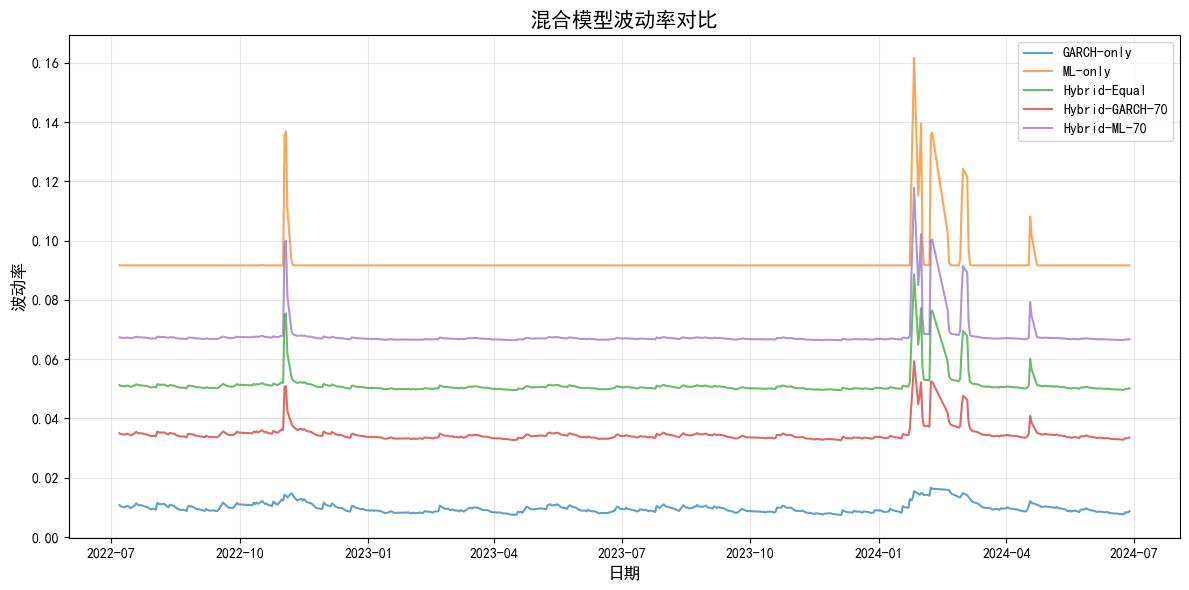

,GARCH-only,ML-only,Hybrid-Equal,Hybrid-GARCH-70,Hybrid-ML-70
trade_date,,,,,
2022-07-07,0.010735,0.091635,0.051185,0.035005,0.067365
2022-07-08,0.010330,0.091635,0.050982,0.034722,0.067243
2022-07-11,0.009960,0.091635,0.050797,0.034462,0.067132
2022-07-12,0.010417,0.091635,0.051026,0.034782,0.067269
2022-07-13,0.010462,0.091635,0.051048,0.034814,0.067283


In [22]:
def build_hybrid_models(garch_volatility, ml_predictions, test_period):
    """
    构建GARCH-ML混合模型
    """
    # 确保在同一时间期间
    common_index = garch_volatility.index.intersection(ml_predictions.index).intersection(test_period)
    
    # 获取该时间段的数据
    garch_vol = garch_volatility.loc[common_index]
    ml_pred = ml_predictions.loc[common_index]
    
    # 构建不同的混合策略
    hybrid_models = {
        'GARCH-only': garch_vol,
        'ML-only': ml_pred,
        'Hybrid-Equal': 0.5 * garch_vol + 0.5 * ml_pred,
        'Hybrid-GARCH-70': 0.7 * garch_vol + 0.3 * ml_pred,
        'Hybrid-ML-70': 0.3 * garch_vol + 0.7 * ml_pred
    }
    
    hybrid_df = pd.DataFrame(hybrid_models)
    
    # 绘制混合模型波动率
    plt.figure(figsize=(12, 6))
    for name, series in hybrid_models.items():
        plt.plot(series.index, series, label=name, alpha=0.7)
    
    plt.title('混合模型波动率对比', fontsize=15)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('波动率', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return hybrid_df

# 构建混合模型
# 使用GRU预测作为ML组件 (也可以选择LSTM或其他预测)
hybrid_models = build_hybrid_models(
    garch_volatility=garch_volatility, 
    ml_predictions=gru_predictions,
    test_period=gru_actuals.index
)
hybrid_models.head()

In [23]:
def build_advanced_hybrid_model(garch_vol, lstm_pred, gru_pred,
                                returns, window_size: int = 22):
    """
    构建高级混合模型，并返回 (混合预测, 结果DataFrame)
    ---------------------------------------------------
    - 使用滚动 MSE 动态分配权重
    - 在高波动期下调 GARCH 权重
    """
    # —— 对齐索引 —— #
    common_index = (
        garch_vol.index
        .intersection(lstm_pred.index)
        .intersection(gru_pred.index)
        .intersection(returns.index)
    )

    garch_vol = garch_vol.loc[common_index]
    lstm_pred = lstm_pred.loc[common_index]
    gru_pred  = gru_pred.loc[common_index]
    returns   = returns.loc[common_index]

    # —— 1. 计算滚动 MSE（允许非完整窗口：min_periods=1） —— #
    def rolling_mse(actual, pred, window):
        error = (actual - pred) ** 2
        return error.rolling(window, min_periods=1).mean()

    actual_vol = returns.abs()                       # 绝对收益≈真实波动
    garch_mse  = rolling_mse(actual_vol, garch_vol, window_size)
    lstm_mse   = rolling_mse(actual_vol, lstm_pred, window_size)
    gru_mse    = rolling_mse(actual_vol, gru_pred,  window_size)

    # —— 2. 动态权重；误差越小权重越大 —— #
    total_error  = garch_mse + lstm_mse + gru_mse
    garch_weight = 1 - (garch_mse / total_error)
    lstm_weight  = 1 - (lstm_mse  / total_error)
    gru_weight   = 1 - (gru_mse   / total_error)

    # 将 NaN（首个窗口）填 0，再标准化
    garch_weight = garch_weight.fillna(0)
    lstm_weight  = lstm_weight.fillna(0)
    gru_weight   = gru_weight.fillna(0)

    sum_w = garch_weight + lstm_weight + gru_weight
    garch_weight /= sum_w
    lstm_weight  /= sum_w
    gru_weight   /= sum_w

    # —— 3. 基础混合预测 —— #
    hybrid_vol = (
        garch_weight * garch_vol
        + lstm_weight  * lstm_pred
        + gru_weight   * gru_pred
    )

    # —— 4. 高波动期修正：>75% 分位 —— #
    market_vol       = returns.abs().rolling(window_size).mean()
    high_vol_mask    = market_vol > market_vol.quantile(0.75)

    # 机器学习成分占比提高
    hybrid_vol.loc[high_vol_mask] = (
        0.4 * garch_vol.loc[high_vol_mask]
        + 0.3 * lstm_pred.loc[high_vol_mask]
        + 0.3 * gru_pred.loc[high_vol_mask]
    )

    # —— 5. 结果 DataFrame —— #
    results_df = pd.DataFrame({
        "GARCH权重": garch_weight,
        "LSTM权重":  lstm_weight,
        "GRU权重":   gru_weight,
        "GARCH预测": garch_vol,
        "LSTM预测":  lstm_pred,
        "GRU预测":   gru_pred,
        "混合预测":  hybrid_vol,
    })

    return hybrid_vol, results_df

In [24]:
def hybrid_prediction(garch_pred, ml_pred, adaptive_weight: bool = True):
    """
    双模型混合预测；adaptive_weight=True 时使用波动率变化率调整权重
    """
    if not adaptive_weight:
        return 0.7 * garch_pred + 0.3 * ml_pred

    # —— 波动率变化率 —— #
    vol_change = garch_pred.pct_change().abs().fillna(0)

    # —— Sigmoid 映射到 [0.3, 0.7] —— #
    sigmoid = lambda x: 0.3 + 0.4 / (1 + np.exp(-10 * (x - vol_change.mean())))
    ml_weights    = vol_change.apply(sigmoid)
    garch_weights = 1 - ml_weights

    return garch_weights * garch_pred + ml_weights * ml_pred

In [25]:
def implement_hybrid_models(returns, garch_vol, lstm_pred, gru_pred,
                            window_size: int = 22):
    """
    构建并评估所有混合方案
    返回 (all_predictions, results_df, weights_df)
    """
    # —— 对齐索引 —— #
    common_index = (
        returns.index
        .intersection(garch_vol.index)
        .intersection(lstm_pred.index)
        .intersection(gru_pred.index)
    )

    returns    = returns.loc[common_index]
    garch_vol  = garch_vol.loc[common_index]
    lstm_pred  = lstm_pred.loc[common_index]
    gru_pred   = gru_pred.loc[common_index]

    # —— 1. 四类预测 —— #
    fixed_hybrid        = 0.7  * garch_vol + 0.15 * lstm_pred + 0.15 * gru_pred
    adaptive_hybrid_lstm = hybrid_prediction(garch_vol, lstm_pred, adaptive_weight=True)
    adaptive_hybrid_gru  = hybrid_prediction(garch_vol, gru_pred,  adaptive_weight=True)
    advanced_hybrid, weights_df = build_advanced_hybrid_model(
        garch_vol, lstm_pred, gru_pred, returns, window_size
    )

    all_predictions = pd.DataFrame({
        "GARCH":           garch_vol,
        "LSTM":            lstm_pred,
        "GRU":             gru_pred,
        "固定权重混合":     fixed_hybrid,
        "GARCH-LSTM自适应": adaptive_hybrid_lstm,
        "GARCH-GRU自适应": adaptive_hybrid_gru,
        "高级混合模型":     advanced_hybrid,
    })

    # —— 2. 评估：一次性剔除 NaN —— #
    actual_vol = returns.abs()
    data_eval  = pd.concat(
        [actual_vol.rename("actual"), all_predictions], axis=1
    ).dropna()

    y_true   = data_eval["actual"]
    garch_mse = mean_squared_error(y_true, data_eval["GARCH"])
    garch_mae = mean_absolute_error(y_true, data_eval["GARCH"])

    results = []
    for col in all_predictions.columns:
        y_pred = data_eval[col]
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        results.append({
            "模型": col,
            "MSE": mse,
            "MAE": mae,
            "MSE改进(%)": (1 - mse / garch_mse) * 100,
            "MAE改进(%)": (1 - mae / garch_mae) * 100,
        })

    results_df = pd.DataFrame(results).sort_values("MSE").reset_index(drop=True)

    # =========================
    # 3. 可视化（如不需要可注释）
    # =========================
    # 3-1 波动率对比
    plt.figure(figsize=(15, 8))
    plt.plot(actual_vol.index, actual_vol, label="实际波动率", color="black", alpha=0.7)
    plt.plot(garch_vol.index,     garch_vol, label="GARCH",      color="blue",  alpha=0.6)
    plt.plot(advanced_hybrid.index, advanced_hybrid,
             label="高级混合模型", color="red",   alpha=0.7)
    plt.title("各模型波动率预测对比")
    plt.xlabel("日期"); plt.ylabel("波动率")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.show()

    # 3-2 权重随时间
    plt.figure(figsize=(15, 6))
    plt.plot(weights_df.index, weights_df["GARCH权重"], label="GARCH权重")
    plt.plot(weights_df.index, weights_df["LSTM权重"],  label="LSTM权重")
    plt.plot(weights_df.index, weights_df["GRU权重"],   label="GRU权重")
    plt.title("高级混合模型权重随时间变化")
    plt.xlabel("日期"); plt.ylabel("权重")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.show()

    return all_predictions, results_df, weights_df

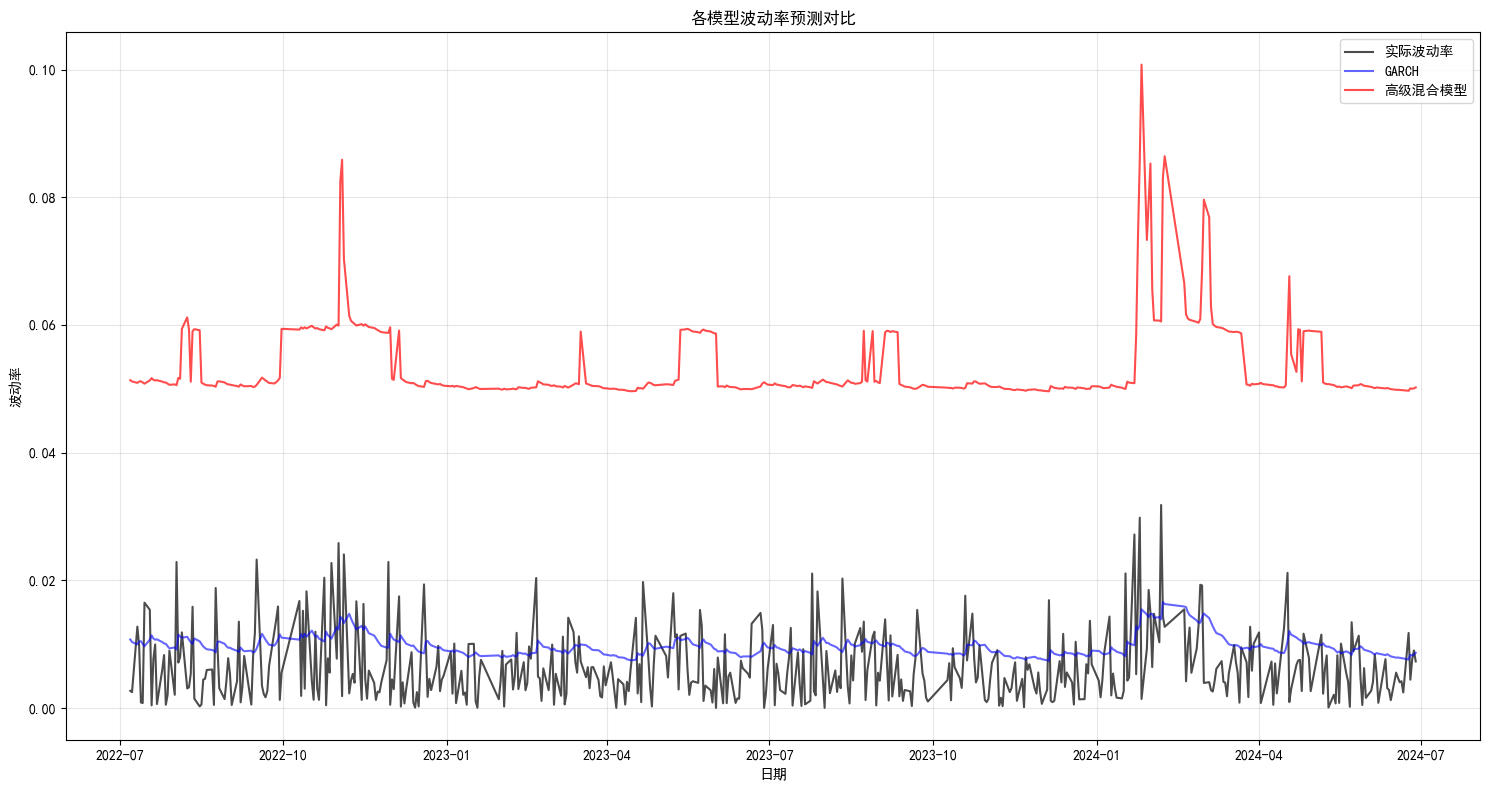

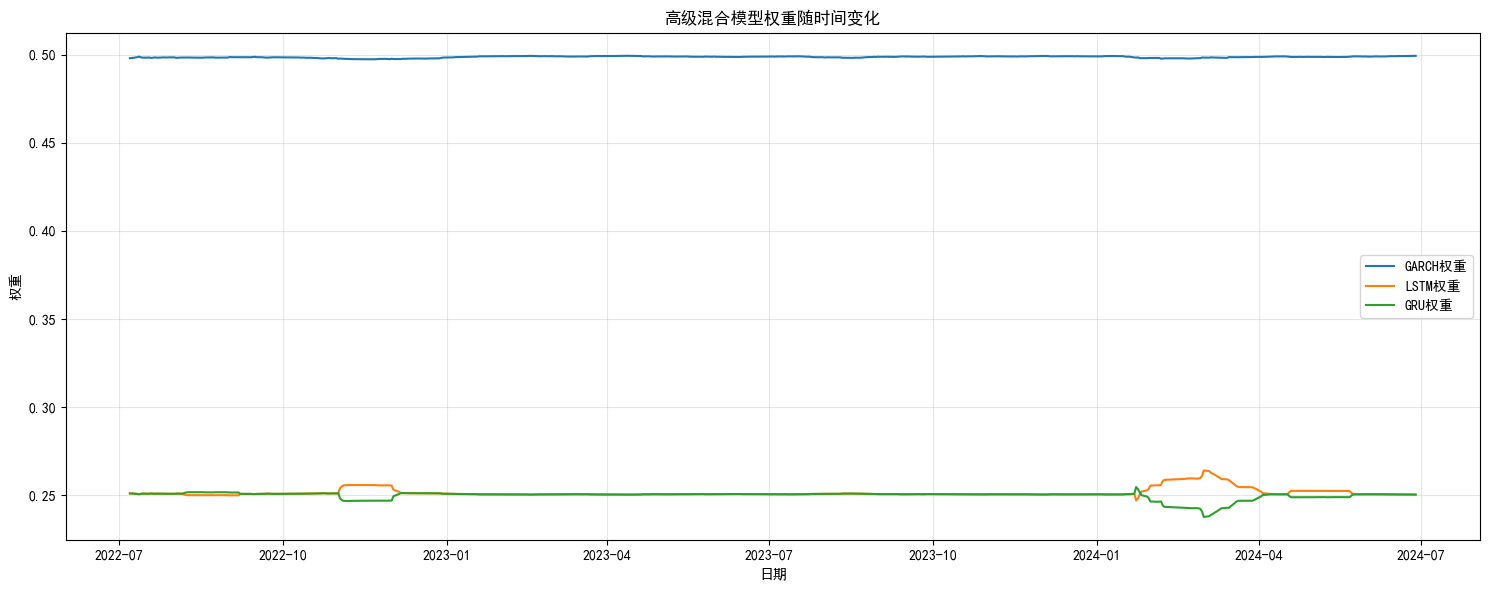


模型性能比较:


,模型,MSE,MAE,MSE改进(%),MAE改进(%)
0,GARCH,0.000041,0.005502,0.000000,0.000000
1,固定权重混合,0.000831,0.028266,-1916.915630,-413.746095
2,GARCH-LSTM自适应,0.002048,0.044694,-4871.711286,-712.338816
3,GARCH-GRU自适应,0.002063,0.044822,-4908.243827,-714.657819
4,高级混合模型,0.002259,0.046963,-5385.608578,-753.568045
5,LSTM,0.007489,0.086235,-18080.864162,-1467.350815
6,GRU,0.007544,0.086482,-18214.666008,-1471.849434


In [26]:
# 5. 实现混合模型
all_predictions, model_results, model_weights = implement_hybrid_models(
    returns, garch_volatility, lstm_predictions, gru_predictions
)
print("\n模型性能比较:")
model_results

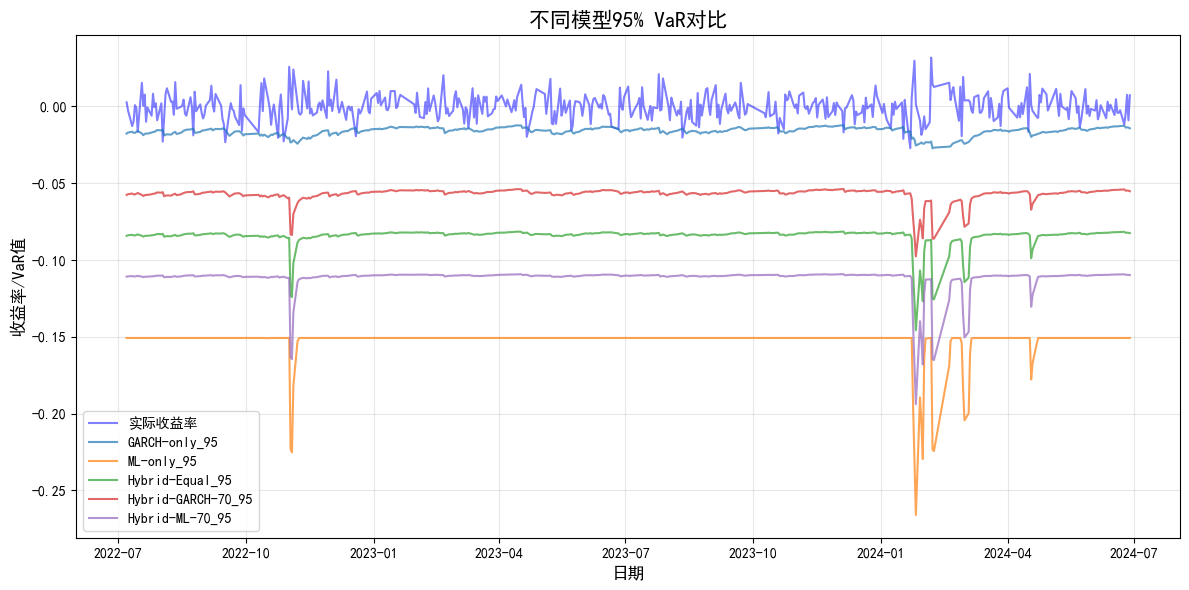

In [27]:
def calculate_var(returns, volatilities, confidence_levels=[0.95, 0.99]):
    """
    计算不同置信水平的VaR
    """
    # 确保在同一时间段
    common_index = returns.index.intersection(volatilities.index)
    returns_common = returns.loc[common_index]
    
    var_results = {}
    
    for level in confidence_levels:
        alpha = 1 - level
        z_score = stats.norm.ppf(alpha)
        
        var_df = pd.DataFrame(index=common_index)
        
        for col in volatilities.columns:
            vol = volatilities.loc[common_index, col]
            var = -z_score * vol  # 这里假设均值为0，实际应用中可能需要加入条件均值
            var_df[f'{col}_{int(level*100)}'] = var
        
        var_results[f'VaR_{int(level*100)}'] = var_df
    
    # 绘制不同模型的95% VaR
    plt.figure(figsize=(12, 6))
    plt.plot(returns_common.index, returns_common, label='实际收益率', color='blue', alpha=0.5)
    
    for col in var_results['VaR_95'].columns:
        plt.plot(var_results['VaR_95'].index, -var_results['VaR_95'][col], 
               label=f'{col}', alpha=0.7)
    
    plt.title('不同模型95% VaR对比', fontsize=15)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('收益率/VaR值', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return var_results

# 计算测试期的收益率
test_returns = returns.loc[hybrid_models.index]

# 计算VaR
var_results = calculate_var(
    returns=test_returns, 
    volatilities=hybrid_models, 
    confidence_levels=[0.95, 0.99]
)

In [28]:
def backtest_var(returns, var_predictions, confidence_level):
    """
    回测VaR模型
    """
    # 确保在同一时间段
    common_index = returns.index.intersection(var_predictions.index)
    returns_common = returns.loc[common_index]
    var_common = var_predictions.loc[common_index]
    
    alpha = 1 - confidence_level
    expected_violations = len(common_index) * alpha
    
    results = []
    
    for col in var_common.columns:
        # 检查VaR突破
        violations = (returns_common < -var_common[col])
        violation_count = violations.sum()
        violation_rate = violation_count / len(common_index)
        
        # kupiec测试
        if violation_count == 0:
            kupiec_stat = -2 * np.log((1 - alpha) ** len(common_index))
        else:
            kupiec_stat = -2 * (np.log((1 - alpha) ** (len(common_index) - violation_count) * 
                               alpha ** violation_count) - 
                              np.log((1 - violation_rate) ** (len(common_index) - violation_count) * 
                                    violation_rate ** violation_count))
        kupiec_pvalue = 1 - stats.chi2.cdf(kupiec_stat, 1)
        
        # 独立性测试
        prev_violations = violations.shift(1).fillna(False)
        
        n00 = ((~prev_violations) & (~violations)).sum()
        n01 = ((~prev_violations) & violations).sum()
        n10 = (prev_violations & (~violations)).sum()
        n11 = (prev_violations & violations).sum()
        
        if n00 == 0 or n01 == 0 or n10 == 0 or n11 == 0:
            ind_stat = 0
            ind_pvalue = 1
        else:
            pi0 = n01 / (n00 + n01)
            pi1 = n11 / (n10 + n11)
            pi = (n01 + n11) / (n00 + n01 + n10 + n11)
            
            ind_stat = -2 * (np.log((1 - pi) ** (n00 + n10) * pi ** (n01 + n11)) - 
                           np.log((1 - pi0) ** n00 * pi0 ** n01 * (1 - pi1) ** n10 * pi1 ** n11))
            ind_pvalue = 1 - stats.chi2.cdf(ind_stat, 1)
        
        # 条件覆盖测试
        cc_stat = kupiec_stat + ind_stat
        cc_pvalue = 1 - stats.chi2.cdf(cc_stat, 2)
        
        results.append({
            '模型': col,
            '期望违约次数': expected_violations,
            '实际违约次数': violation_count,
            '违约率': violation_rate,
            'Kupiec p值': kupiec_pvalue,
            '独立性 p值': ind_pvalue,
            '条件覆盖 p值': cc_pvalue,
            'Kupiec通过': kupiec_pvalue > 0.05,
            '独立性通过': ind_pvalue > 0.05,
            '条件覆盖通过': cc_pvalue > 0.05
        })
    
    results_df = pd.DataFrame(results)
    
    return results_df

# 回测95% VaR
backtest_95 = backtest_var(
    returns=test_returns, 
    var_predictions=var_results['VaR_95'], 
    confidence_level=0.95
)
print("95% VaR回测结果:")
backtest_95

95% VaR回测结果:


,模型,期望违约次数,实际违约次数,违约率,Kupiec p值,独立性 p值,条件覆盖 p值,Kupiec通过,独立性通过,条件覆盖通过
0,GARCH-only_95,24.0,17,0.035417,1.227141e-01,1,3.038665e-01,True,True,True
1,ML-only_95,24.0,0,0.000000,2.263079e-12,1,2.029221e-11,False,True,False
2,Hybrid-Equal_95,24.0,0,0.000000,2.263079e-12,1,2.029221e-11,False,True,False
3,Hybrid-GARCH-70_95,24.0,0,0.000000,2.263079e-12,1,2.029221e-11,False,True,False
4,Hybrid-ML-70_95,24.0,0,0.000000,2.263079e-12,1,2.029221e-11,False,True,False


In [29]:
# 回测99% VaR
backtest_99 = backtest_var(
    returns=test_returns, 
    var_predictions=var_results['VaR_99'], 
    confidence_level=0.99
)
print("\n99% VaR回测结果:")
backtest_99


99% VaR回测结果:


,模型,期望违约次数,实际违约次数,违约率,Kupiec p值,独立性 p值,条件覆盖 p值,Kupiec通过,独立性通过,条件覆盖通过
0,GARCH-only_99,4.8,5,0.010417,0.927392,1,0.995857,True,True,True
1,ML-only_99,4.8,0,0.000000,0.001895,1,0.008033,False,True,False
2,Hybrid-Equal_99,4.8,0,0.000000,0.001895,1,0.008033,False,True,False
3,Hybrid-GARCH-70_99,4.8,0,0.000000,0.001895,1,0.008033,False,True,False
4,Hybrid-ML-70_99,4.8,0,0.000000,0.001895,1,0.008033,False,True,False


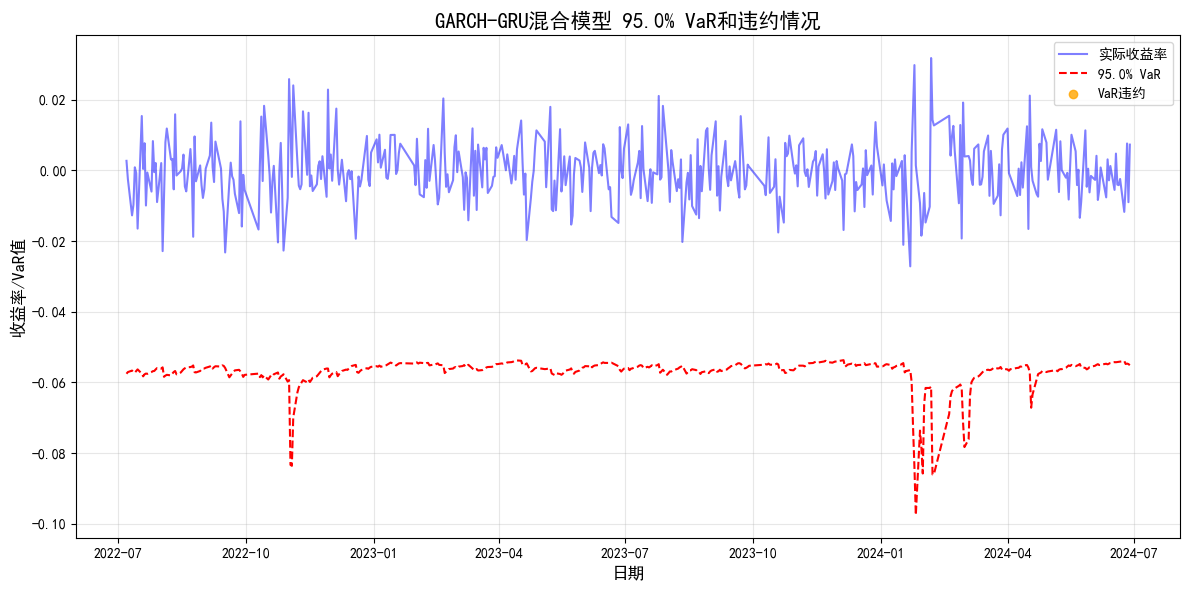

In [30]:
def plot_var_violations(returns, var_values, model_name, confidence_level):
    """
    可视化VaR违约情况
    """
    # 确保在同一时间段
    common_index = returns.index.intersection(var_values.index)
    returns_common = returns.loc[common_index]
    var_common = var_values.loc[common_index]
    
    # 检查违约
    violations = returns_common < -var_common
    violation_points = returns_common[violations]
    
    plt.figure(figsize=(12, 6))
    plt.plot(returns_common.index, returns_common, label='实际收益率', color='blue', alpha=0.5)
    plt.plot(var_common.index, -var_common, label=f'{confidence_level*100}% VaR', 
           color='red', linestyle='--')
    plt.scatter(violation_points.index, violation_points, color='orange', marker='o', 
              label='VaR违约', alpha=0.8)
    
    plt.title(f'{model_name} {confidence_level*100}% VaR和违约情况', fontsize=15)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('收益率/VaR值', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 选择混合模型可视化VaR违约情况
best_model_col = 'Hybrid-GARCH-70_95'
plot_var_violations(
    returns=test_returns, 
    var_values=var_results['VaR_95'][best_model_col], 
    model_name='GARCH-GRU混合模型', 
    confidence_level=0.95
)

In [31]:
def comprehensive_evaluation(model_comparison, var_backtest_95, var_backtest_99):
    """
    综合评估不同模型的表现
    """
    # 波动率预测性能
    print("波动率预测性能:")
    print(model_comparison)
    print("\n")
    
    # VaR回测性能
    print("VaR回测性能总结:")
    
    # 95% VaR性能
    print("\n95% VaR回测结果:")
    var_95_performance = var_backtest_95[['模型', '期望违约次数', '实际违约次数', '违约率', 
                                        'Kupiec通过', '独立性通过', '条件覆盖通过']]
    print(var_95_performance)
    
    # 99% VaR性能
    print("\n99% VaR回测结果:")
    var_99_performance = var_backtest_99[['模型', '期望违约次数', '实际违约次数', '违约率', 
                                        'Kupiec通过', '独立性通过', '条件覆盖通过']]
    print(var_99_performance)
    
    # 最佳模型推荐
    best_models = []
    
    # 波动率预测最佳模型
    best_vol_model = model_comparison.sort_values('MSE').iloc[0]['模型']
    best_models.append(f"波动率预测最佳模型: {best_vol_model}")
    
    # 95% VaR最佳模型
    var_95_passed = var_backtest_95[var_backtest_95['条件覆盖通过']]
    if not var_95_passed.empty:
        # 从通过检验的模型中，选择违约率最接近理论值的
        theoretical_rate = 0.05
        var_95_passed['偏差'] = abs(var_95_passed['违约率'] - theoretical_rate)
        best_var_95 = var_95_passed.sort_values('偏差').iloc[0]['模型']
        best_models.append(f"95% VaR最佳模型: {best_var_95}")
    else:
        best_models.append("没有模型通过95% VaR的所有回测检验")
    
    # 99% VaR最佳模型
    var_99_passed = var_backtest_99[var_backtest_99['条件覆盖通过']]
    if not var_99_passed.empty:
        # 从通过检验的模型中，选择违约率最接近理论值的
        theoretical_rate = 0.01
        var_99_passed['偏差'] = abs(var_99_passed['违约率'] - theoretical_rate)
        best_var_99 = var_99_passed.sort_values('偏差').iloc[0]['模型']
        best_models.append(f"99% VaR最佳模型: {best_var_99}")
    else:
        best_models.append("没有模型通过99% VaR的所有回测检验")
    
    print("\n最佳模型推荐:")
    for model in best_models:
        print(model)
    
    return best_models

# 进行综合评估
best_models = comprehensive_evaluation(
    model_comparison=model_comparison,
    var_backtest_95=backtest_95,
    var_backtest_99=backtest_99
)

波动率预测性能:
      模型       MSE       MAE
0  GARCH  0.002532  0.045016
1   LSTM  0.001873  0.039042
2    GRU  0.001870  0.038921


VaR回测性能总结:

95% VaR回测结果:
                   模型  期望违约次数  实际违约次数       违约率  Kupiec通过  独立性通过  条件覆盖通过
0       GARCH-only_95    24.0      17  0.035417      True   True    True
1          ML-only_95    24.0       0  0.000000     False   True   False
2     Hybrid-Equal_95    24.0       0  0.000000     False   True   False
3  Hybrid-GARCH-70_95    24.0       0  0.000000     False   True   False
4     Hybrid-ML-70_95    24.0       0  0.000000     False   True   False

99% VaR回测结果:
                   模型  期望违约次数  实际违约次数       违约率  Kupiec通过  独立性通过  条件覆盖通过
0       GARCH-only_99     4.8       5  0.010417      True   True    True
1          ML-only_99     4.8       0  0.000000     False   True   False
2     Hybrid-Equal_99     4.8       0  0.000000     False   True   False
3  Hybrid-GARCH-70_99     4.8       0  0.000000     False   True   False
4     Hybrid-ML-70_99     4.8  